# Import Libraries

In [227]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [228]:
# Patient Data
patients = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')

# Transfer Data
transfers = pd.read_csv('mimic-iii-clinical-database-demo-1.4/TRANSFERS.csv')

# Prescription Data
prescriptions = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv')

# Lab Events Data
lab_items = pd.read_csv('mimic-iii-clinical-database-demo-1.4/D_LABITEMS.csv')
lab_events = pd.read_csv('mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv', parse_dates=['charttime'])

# Procedures Data
procedures = pd.read_csv('mimic-iii-clinical-database-demo-1.4/PROCEDURES_ICD.csv')
procedures_labels = pd.read_csv('mimic-iii-clinical-database-demo-1.4/D_ICD_PROCEDURES.csv')

## Patients Table (From Tutorial)

In [229]:
from datetime import datetime
filtered_patients = patients
# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
filtered_patients["age"] = filtered_patients.apply(lambda row: calculate_age(row["dob"], row["dod"]), axis=1)

# Filter out rows with age greater than or equal to 120
filtered_patients = filtered_patients[filtered_patients["age"] < 120]

# Display the updated DataFrame
print(filtered_patients.head())

   row_id  subject_id gender                  dob                  dod  \
0    9467       10006      F  2094-03-05 00:00:00  2165-08-12 00:00:00   
1    9472       10011      F  2090-06-05 00:00:00  2126-08-28 00:00:00   
2    9474       10013      F  2038-09-03 00:00:00  2125-10-07 00:00:00   
3    9478       10017      F  2075-09-21 00:00:00  2152-09-12 00:00:00   
4    9479       10019      M  2114-06-20 00:00:00  2163-05-15 00:00:00   

              dod_hosp              dod_ssn  expire_flag  age  
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1   71  
1  2126-08-28 00:00:00                  NaN            1   36  
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1   87  
3                  NaN  2152-09-12 00:00:00            1   77  
4  2163-05-15 00:00:00  2163-05-15 00:00:00            1   48  


### Patients Age Distribution By Gender

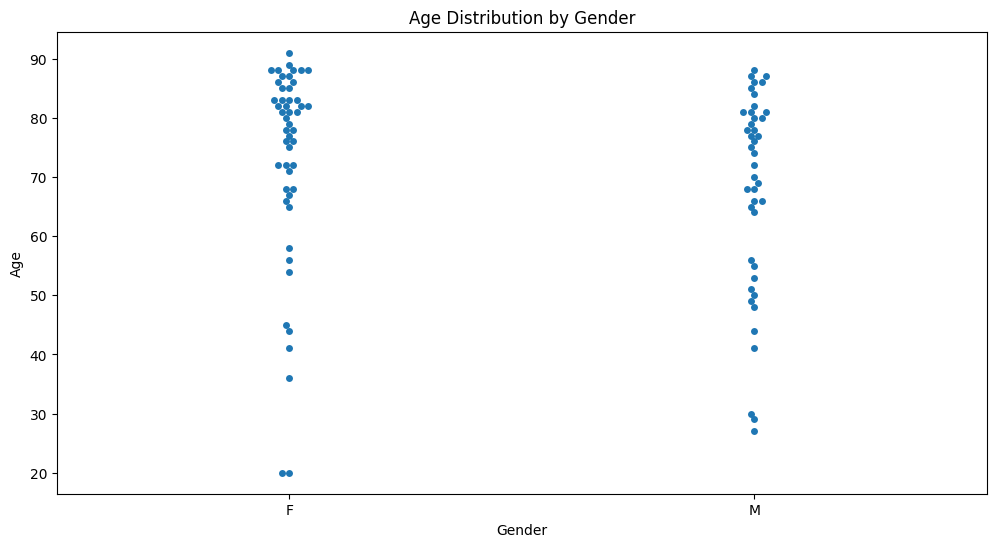

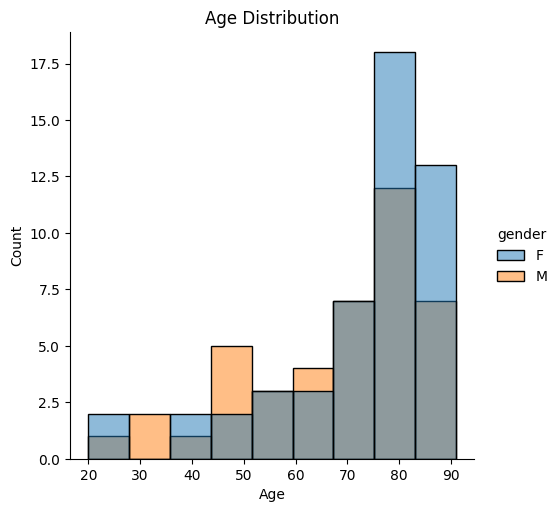

In [230]:
# Create swarm plot of age distribution by gender
plt.figure(figsize=(12, 6))

sns.swarmplot(data=filtered_patients, y='age', x='gender')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

sns.displot(data=filtered_patients, x='age', hue='gender')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Patient Gender Distribution

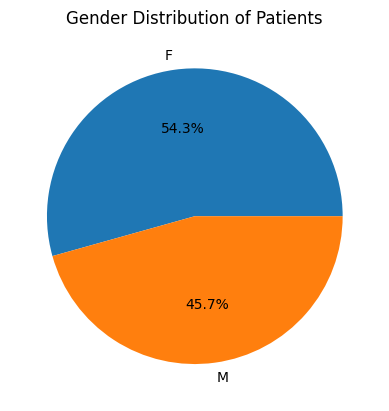

In [231]:

# Count patients by gender
gender_counts = filtered_patients['gender'].value_counts()

# Create a pie chart
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution of Patients')
plt.show()


## Analyze Transfer Data

In [232]:
merged_transfers_patients = pd.merge(transfers, filtered_patients, on='subject_id')
merged_transfers_patients.head()

row_id_x  subject_id  hadm_id  icustay_id dbsource  eventtype  \
0     54440       10006   142345    206504.0  carevue      admit   
1     54441       10006   142345         NaN  carevue   transfer   
2     54442       10006   142345         NaN  carevue  discharge   
3     54460       10011   105331    232110.0  carevue      admit   
4     54461       10011   105331         NaN  carevue  discharge   

  prev_careunit curr_careunit  prev_wardid  curr_wardid  ...  \
0           NaN          MICU          NaN         52.0  ...   
1          MICU           NaN         52.0         45.0  ...   
2           NaN           NaN         45.0          NaN  ...   
3           NaN          MICU          NaN         15.0  ...   
4          MICU           NaN         15.0          NaN  ...   

               outtime     los  row_id_y  gender                  dob  \
0  2164-10-25 12:21:07   39.18      9467       F  2094-03-05 00:00:00   
1  2164-11-01 17:14:27  172.89      9467       F  2094-03-05 00:00:00   
2                  NaN     NaN      9467       F  2094-03-05 00:00:00   
3  2126-08-28 18:59:00  332.42      9472       F  2090-06-05 00:00:00   
4                  NaN     NaN      9472       F  2090-06-05 00:00:00   

                   dod             dod_hosp              dod_ssn expire_flag  \
0  2165-08-12 00:00:00  2165-08-12 00:00:00  2165-08-12 00:00:00           1   
1  2165-08-12 00:00:00  2165-08-12 00:00:00  2165-08-12 00:00:00           1   
2  2165-08-12 00:00:00  2165-08-12 00:00:00  2165-08-12 00:00:00           1   
3  2126-08-28 00:00:00  2126-08-28 00:00:00                  NaN           1   
4  2126-08-28 00:00:00  2126-08-28 00:00:00                  NaN           1   

   age  
0   71  
1   71  
2   71  
3   36  
4   36  

[5 rows x 21 columns]

### Analyze Number of Transfers and Length of Stay

Text(0, 0.5, 'Count')

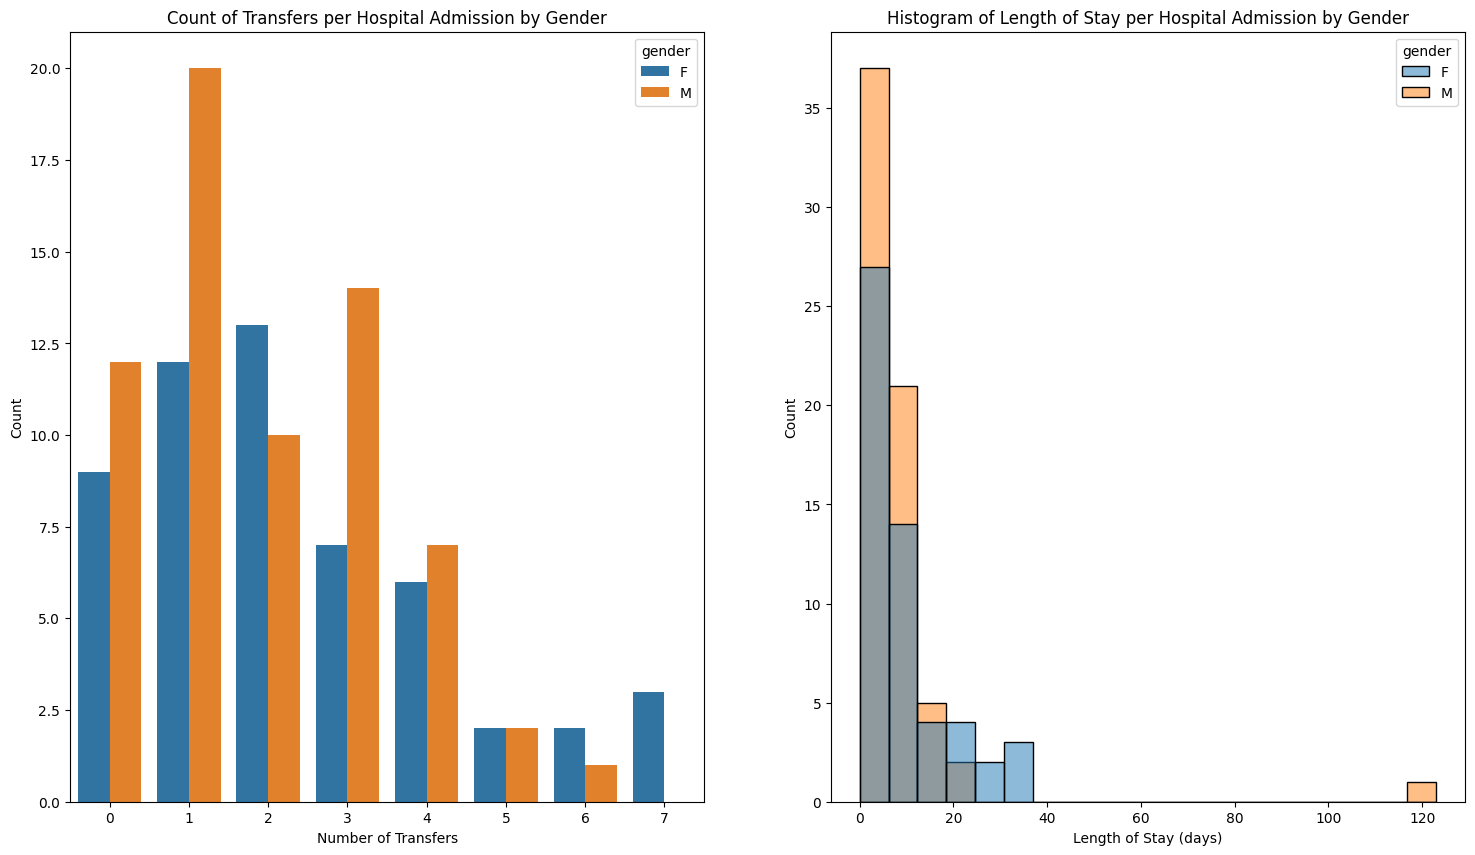

In [233]:
# Calculate number of transfers per hospital admission and get admission/discharge times
transfers_and_los_per_patient = merged_transfers_patients.groupby('hadm_id').agg(
    num_transfers=('eventtype', lambda x: (x == 'transfer').sum()),
    admit_time=('intime', lambda x: x[merged_transfers_patients.loc[x.index, 'eventtype'] == 'admit'].iloc[0] if any(merged_transfers_patients.loc[x.index, 'eventtype'] == 'admit') else None),
    discharge_time=('intime', lambda x: x[merged_transfers_patients.loc[x.index, 'eventtype'] == 'discharge'].iloc[0] if any(merged_transfers_patients.loc[x.index, 'eventtype'] == 'discharge') else None),
    gender=('gender', lambda x: x[merged_transfers_patients.loc[x.index, 'eventtype'] == 'admit'].iloc[0] if any(merged_transfers_patients.loc[x.index, 'eventtype'] == 'admit') else None)
).reset_index()

transfers_and_los_per_patient['los'] = (pd.to_datetime(transfers_and_los_per_patient['discharge_time']) - pd.to_datetime(transfers_and_los_per_patient['admit_time'])).dt.days

# Create a complex visualization
plt.figure(figsize=(18, 10))

# Count plot of Transfers per Hospital Admission by Gender
plt.subplot(1, 2, 1)
sns.countplot(data=transfers_and_los_per_patient, x='num_transfers', hue='gender')
plt.title("Count of Transfers per Hospital Admission by Gender")
plt.xlabel("Number of Transfers")
plt.ylabel("Count")

# Histogram of Length of Stay by Gender
plt.subplot(1, 2, 2)
sns.histplot(data=transfers_and_los_per_patient, x='los', bins=20, hue='gender')
plt.title("Histogram of Length of Stay per Hospital Admission by Gender")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Count")


### Analyze the wards that a patient is in during their hospital stay


Sample of ward sequences by hospital admission:
   hadm_id     wards gender  age
0   100375  [52, 18]      F   83
1   100969  [57, 31]      M   81
2   101361  [52, 18]      M   55
3   102203  [54, 23]      M   44
4   103379  [54, 57]      F   58

Summary statistics:
Average number of unique wards per admission: 2.35
Maximum number of unique wards per admission: 6
Minimum number of unique wards per admission: 1


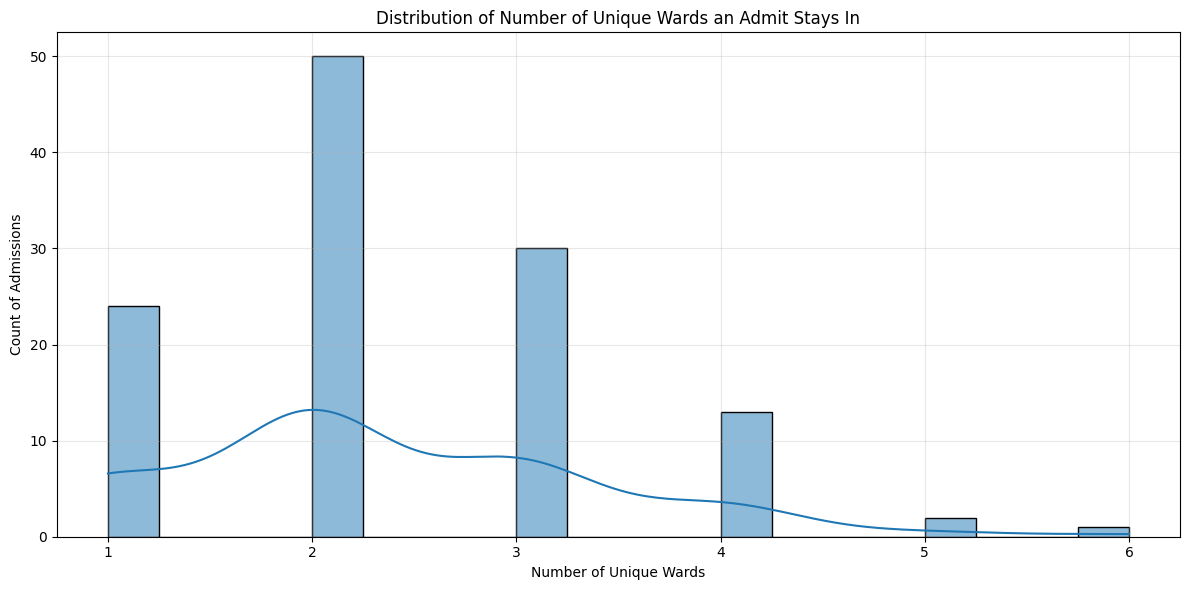

In [234]:
# Get list of wards for each hospital admission
ward_list = merged_transfers_patients.groupby('hadm_id').agg(
    wards=('curr_wardid', lambda x: list(x.dropna().unique())),
    gender=('gender', 'first'),
    age=('age', 'first')
).reset_index()

# Convert ward IDs to integers
ward_list['wards'] = ward_list['wards'].apply(lambda x: [int(w) for w in x])

# Print first few rows to verify
print("Sample of ward sequences by hospital admission:")
print(ward_list.head())

# Get some basic statistics
print("\nSummary statistics:")
print(f"Average number of unique wards per admission: {ward_list['wards'].apply(len).mean():.2f}")
print(f"Maximum number of unique wards per admission: {ward_list['wards'].apply(len).max()}")
print(f"Minimum number of unique wards per admission: {ward_list['wards'].apply(len).min()}")

# Calculate number of unique wards per admission
unique_wards_count = ward_list['wards'].apply(len)

# Create distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(data=unique_wards_count, bins=20, kde=True)
plt.title('Distribution of Number of Unique Wards an Admit Stays In')
plt.xlabel('Number of Unique Wards')
plt.ylabel('Count of Admissions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

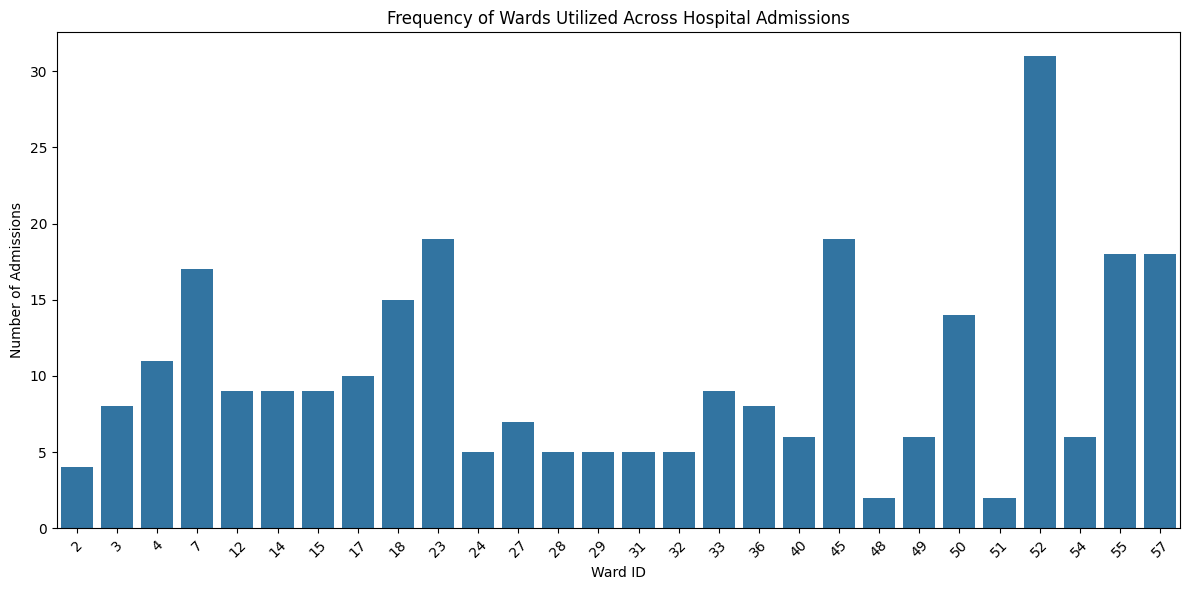

In [235]:
# Get frequency count of each ward across all admissions
ward_frequencies = {}
for wards in ward_list['wards']:
    for ward in wards:
        ward_frequencies[ward] = ward_frequencies.get(ward, 0) + 1

# Convert to DataFrame for plotting
ward_freq_df = pd.DataFrame.from_dict(ward_frequencies, orient='index', columns=['count'])
ward_freq_df.index.name = 'ward'
ward_freq_df = ward_freq_df.reset_index()
ward_freq_df = ward_freq_df.sort_values('count', ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=ward_freq_df, x='ward', y='count')
plt.title('Frequency of Wards Utilized Across Hospital Admissions')
plt.xlabel('Ward ID')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45)
plt.tight_layout()


### Analyze Event Types by Gender and Age

([0, 1, 2],
 [Text(0, 0, 'admit'), Text(1, 0, 'transfer'), Text(2, 0, 'discharge')])

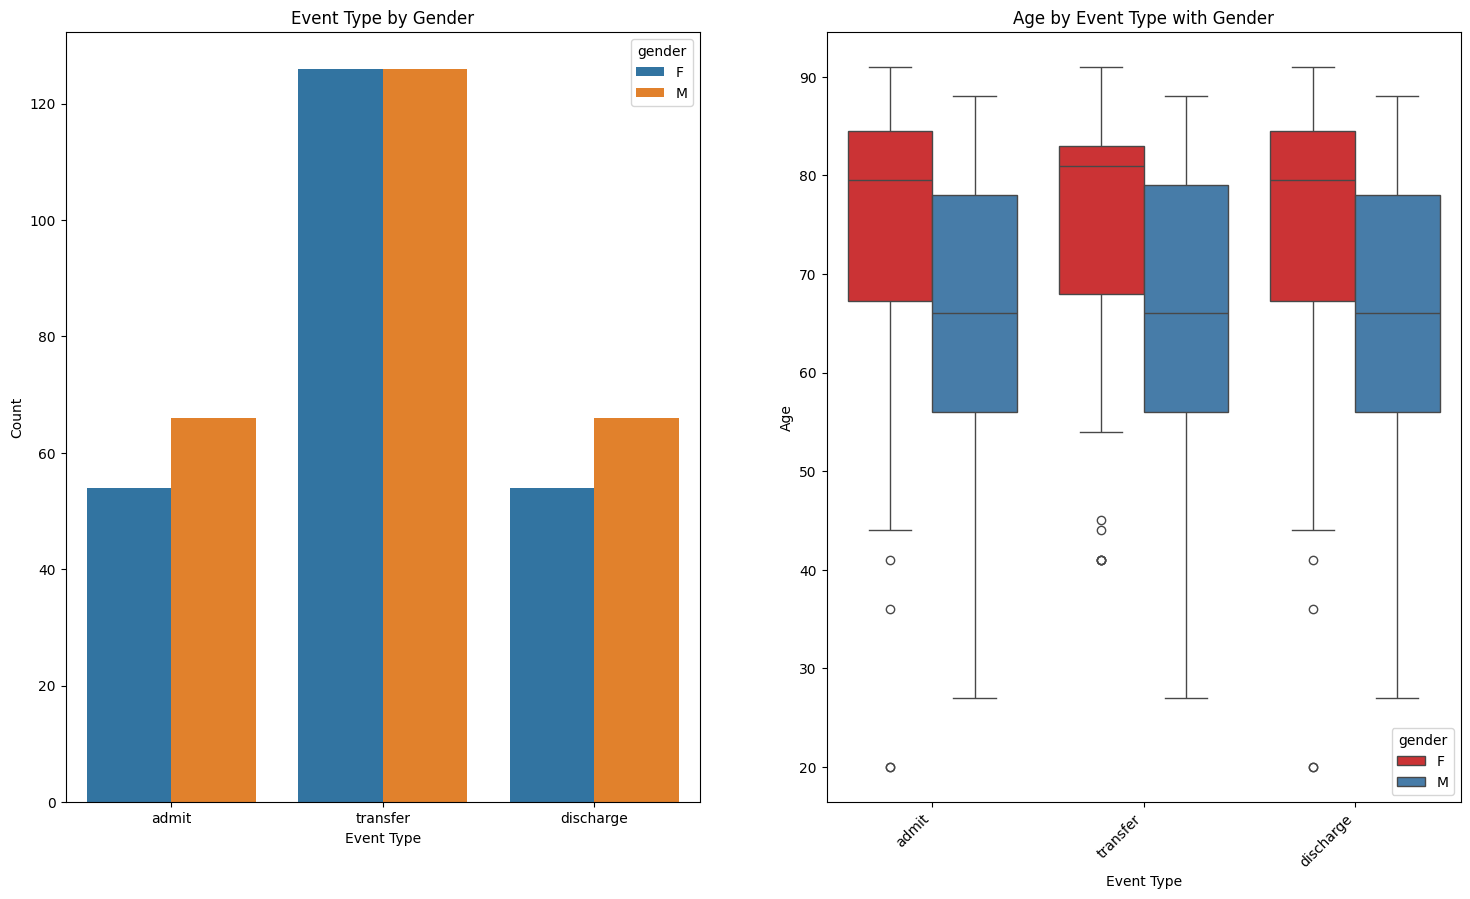

In [236]:
# Create a complex visualization
plt.figure(figsize=(18, 10))

# Count plot of Admission Types by Gender
plt.subplot(1, 2, 1)
sns.countplot(data=merged_transfers_patients, x='eventtype', hue='gender')
plt.title("Event Type by Gender")
plt.xlabel("Event Type")
plt.ylabel("Count")

# Box plot of Age by Event Type with Gender color hue
plt.subplot(1, 2, 2)
sns.boxplot(data=merged_transfers_patients, x='eventtype', y='age', hue='gender', palette='Set1')
plt.title("Age by Event Type with Gender")
plt.xlabel("Event Type")
plt.ylabel("Age")
plt.xticks(rotation=45, ha='right')




### Analyze Admit Data and Discharge Data


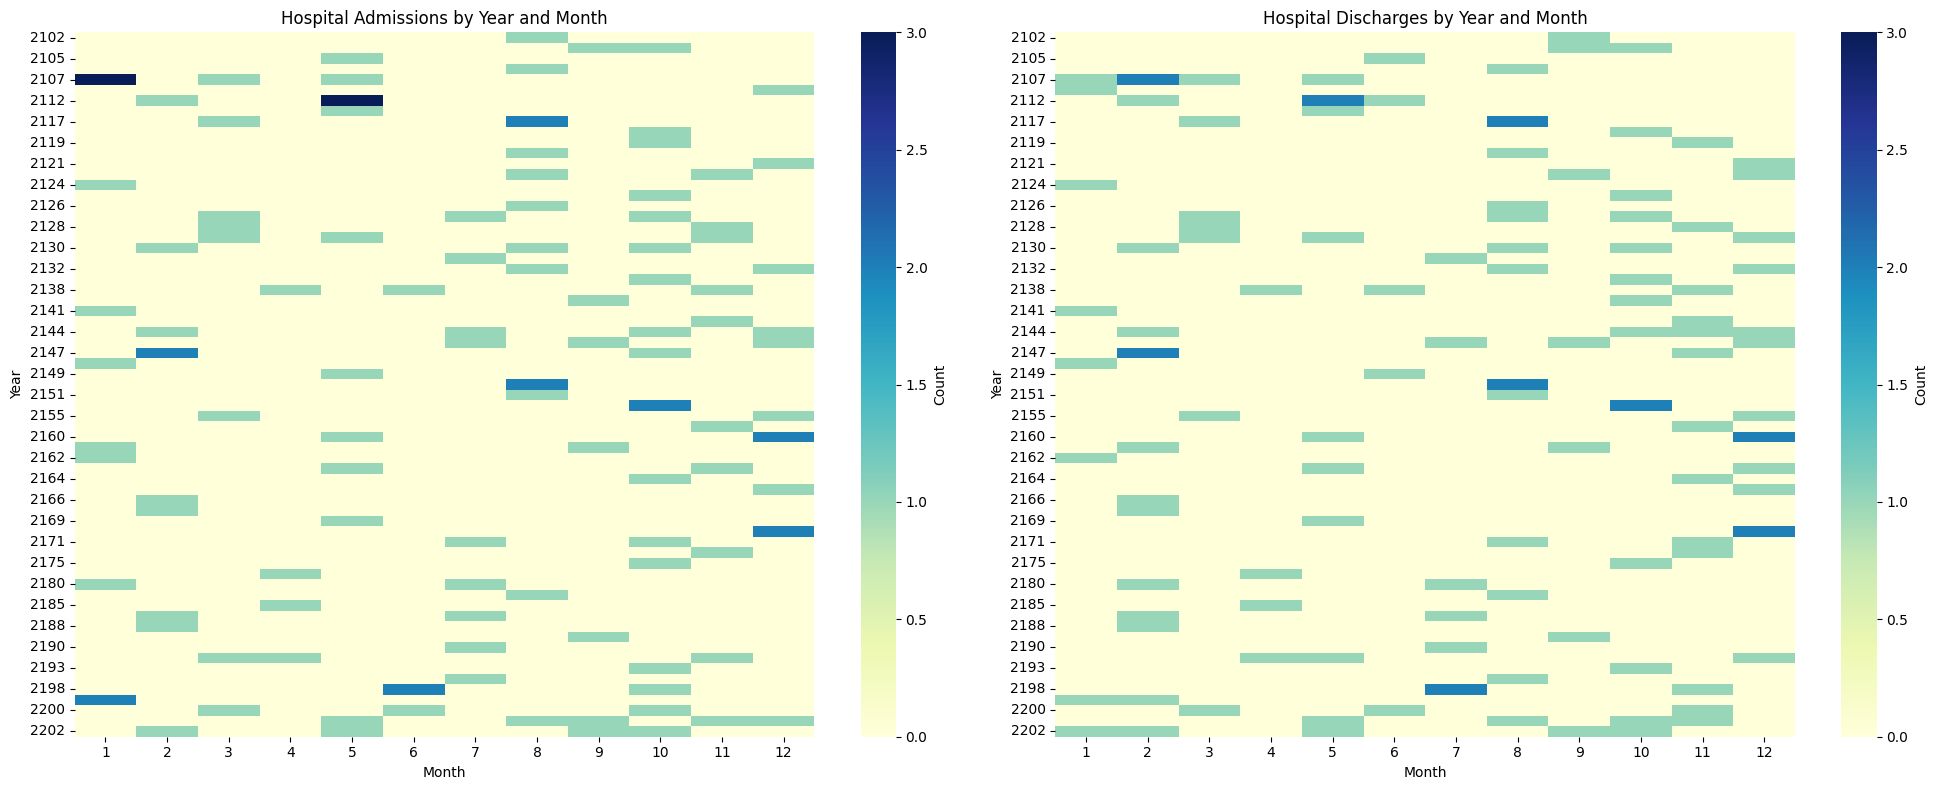

In [237]:
# Extract year and month from admit and discharge times
admit_patterns = pd.DataFrame(pd.to_datetime(transfers_and_los_per_patient['admit_time']))
discharge_patterns = pd.DataFrame(pd.to_datetime(transfers_and_los_per_patient['discharge_time']))

# Create year and month columns
admit_patterns['year'] = admit_patterns['admit_time'].dt.year
admit_patterns['month'] = admit_patterns['admit_time'].dt.month
discharge_patterns['year'] = discharge_patterns['discharge_time'].dt.year
discharge_patterns['month'] = discharge_patterns['discharge_time'].dt.month

# Create cross-tabulation for heatmap data
admit_heatmap = pd.crosstab(admit_patterns['year'], admit_patterns['month'])
discharge_heatmap = pd.crosstab(discharge_patterns['year'], discharge_patterns['month'])

# Find global min and max for consistent color scaling
vmin = min(admit_heatmap.min().min(), discharge_heatmap.min().min())
vmax = max(admit_heatmap.max().max(), discharge_heatmap.max().max())

# Create figure with two subplots
plt.figure(figsize=(20, 8))

# Admission heatmap
plt.subplot(1, 2, 1)
sns.heatmap(admit_heatmap, vmin=vmin, vmax=vmax, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Count'})
plt.title('Hospital Admissions by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')

# Discharge heatmap
plt.subplot(1, 2, 2)
sns.heatmap(discharge_heatmap, vmin=vmin, vmax=vmax, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})
plt.title('Hospital Discharges by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')

plt.tight_layout()
plt.show()

## Analyze Prescription Data


In [238]:
merged_prescription_patients = pd.merge(prescriptions, filtered_patients, on="subject_id")
merged_prescription_patients.head()


row_id_x  subject_id  hadm_id  icustay_id            startdate  \
0     59637       42275   128293    290478.0  2135-10-25 00:00:00   
1     59638       42275   128293    290478.0  2135-10-25 00:00:00   
2     59639       42275   128293    290478.0  2135-10-25 00:00:00   
3     59640       42275   128293    290478.0  2135-10-25 00:00:00   
4     59641       42275   128293    290478.0  2135-10-25 00:00:00   

               enddate drug_type                         drug  \
0  2135-10-27 00:00:00      MAIN  Sodium Chloride 0.9%  Flush   
1  2135-10-27 00:00:00      MAIN                      Heparin   
2  2135-10-27 00:00:00      MAIN                  Guaifenesin   
3  2135-10-27 00:00:00      MAIN            Albuterol Inhaler   
4  2135-10-27 00:00:00      MAIN                   Amlodipine   

                 drug_name_poe            drug_name_generic  ...  \
0  Sodium Chloride 0.9%  Flush  Sodium Chloride 0.9%  Flush  ...   
1                      Heparin               Heparin Sodium  ...   
2                  Guaifenesin                  Guaifenesin  ...   
3            Albuterol Inhaler            Albuterol Inhaler  ...   
4                   Amlodipine                   Amlodipine  ...   

  form_unit_disp  route  row_id_y gender                  dob  \
0            SYR     IV     31391      M  2058-08-04 00:00:00   
1             mL     SC     31391      M  2058-08-04 00:00:00   
2          UDCUP     PO     31391      M  2058-08-04 00:00:00   
3            INH     IH     31391      M  2058-08-04 00:00:00   
4            TAB     PO     31391      M  2058-08-04 00:00:00   

                   dod             dod_hosp dod_ssn expire_flag  age  
0  2136-03-26 00:00:00  2136-03-26 00:00:00     NaN           1   77  
1  2136-03-26 00:00:00  2136-03-26 00:00:00     NaN           1   77  
2  2136-03-26 00:00:00  2136-03-26 00:00:00     NaN           1   77  
3  2136-03-26 00:00:00  2136-03-26 00:00:00     NaN           1   77  
4  2136-03-26 00:00:00  2136-03-26 00:00:00     NaN           1   77  

[5 rows x 27 columns]

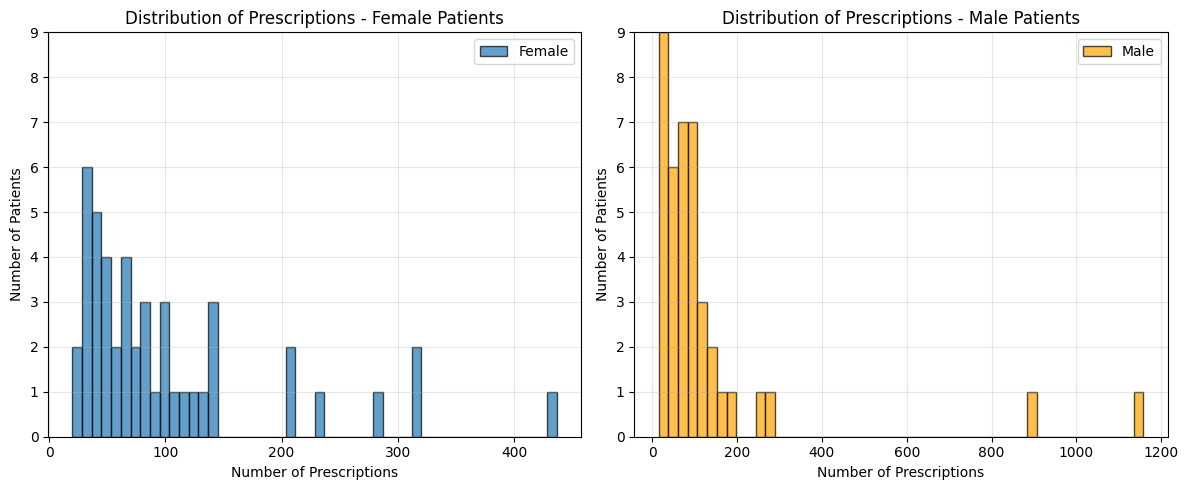

In [239]:
# Show the prescribed drugs count distribution by gender
plt.figure(figsize=(12, 5))

# Count prescriptions for female patients
female_counts = merged_prescription_patients[merged_prescription_patients['gender']=='F']['subject_id'].value_counts()

# Count prescriptions for male patients 
male_counts = merged_prescription_patients[merged_prescription_patients['gender']=='M']['subject_id'].value_counts()

# Find global y-axis limits
ymax = max(np.histogram(female_counts, bins=50)[0].max(), 
           np.histogram(male_counts, bins=50)[0].max())

plt.subplot(1, 2, 1)
plt.hist(female_counts, bins=50, edgecolor='black', alpha=0.7, label='Female')
plt.title('Distribution of Prescriptions - Female Patients')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Patients')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, ymax)

plt.subplot(1, 2, 2)
plt.hist(male_counts, bins=50, edgecolor='black', alpha=0.7, color='orange', label='Male')
plt.title('Distribution of Prescriptions - Male Patients')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Patients')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, ymax)

plt.tight_layout()


C:\Users\patel\AppData\Local\Temp\ipykernel_31220\742604304.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\patel\AppData\Local\Temp\ipykernel_31220\742604304.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




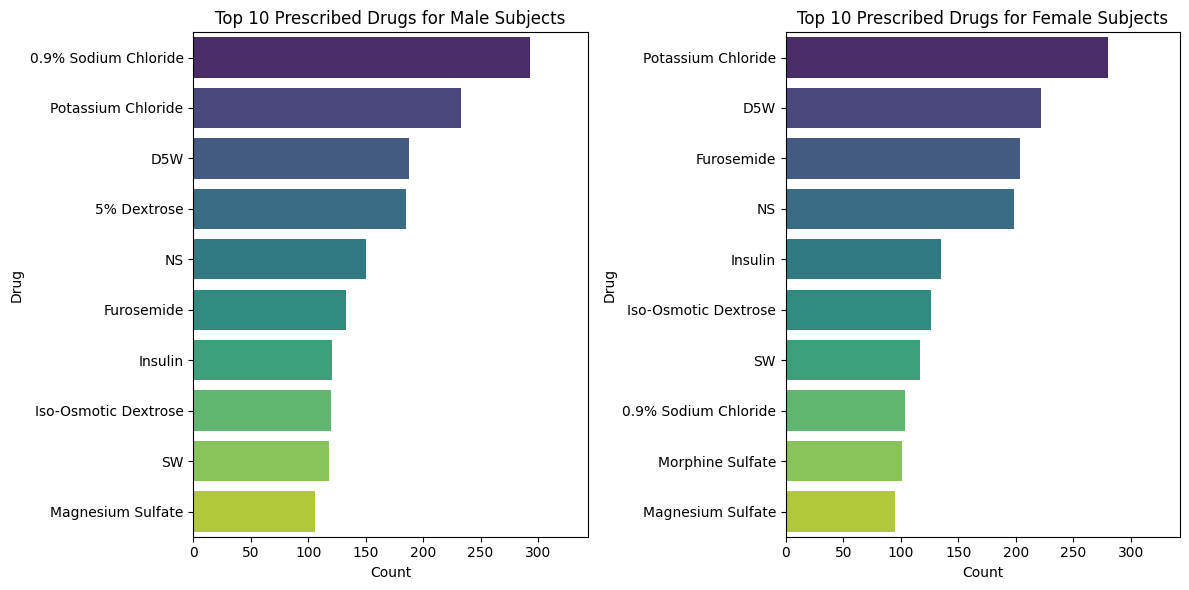

In [240]:
# Get count of drugs prescribed for each gender
prescription_counts_male = merged_prescription_patients[merged_prescription_patients['gender'] == 'M']['drug'].value_counts().head(10)
prescription_counts_female = merged_prescription_patients[merged_prescription_patients['gender'] == 'F']['drug'].value_counts().head(10)

# Find the maximum count to set consistent x-axis scale
max_count = max(prescription_counts_male.max(), prescription_counts_female.max())

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Subplot for Male Subjects
plt.subplot(1, 2, 1)
sns.barplot(x=prescription_counts_male.values, y=prescription_counts_male.index, palette='viridis')
plt.title("Top 10 Prescribed Drugs for Male Subjects")
plt.xlabel("Count")
plt.ylabel("Drug")
plt.xlim(0, max_count + 50)  # Set x-axis limit

# Subplot for Female Subjects
plt.subplot(1, 2, 2)
sns.barplot(x=prescription_counts_female.values, y=prescription_counts_female.index, palette='viridis')
plt.title("Top 10 Prescribed Drugs for Female Subjects")
plt.xlabel("Count")
plt.ylabel("Drug")
plt.xlim(0, max_count + 50)  # Set x-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Using Plotly to visualize such data

In [241]:
import pandas as pd
import plotly.graph_objects as go

# Create a DataFrame for male and female prescription counts
male_df = pd.DataFrame({'drug': prescription_counts_male.index, 'count': prescription_counts_male.values})
female_df = pd.DataFrame({'drug': prescription_counts_female.index, 'count': prescription_counts_female.values})

# Create a new column 'hover_text' that combines 'drug', 'count'
male_df['hover_text'] = male_df['drug'] + '<br>Count: ' + male_df['count'].astype(str)
female_df['hover_text'] = female_df['drug'] + '<br>Count: ' + female_df['count'].astype(str)

# Create treemaps using Plotly Graph Objects with custom hover data and template
fig_male = go.Figure(go.Treemap(
    labels=male_df['drug'],
    parents=[''] * len(male_df),  # Set parent to empty string to remove parent levels
    values=male_df['count'],
    customdata=male_df[['drug', 'hover_text']],
    hovertemplate='<b>%{customdata[0]}</b><br>%{customdata[1]}',
))
fig_male.update_layout(title='Top 10 Prescribed Drugs for Male Subjects')

fig_female = go.Figure(go.Treemap(
    labels=female_df['drug'],
    parents=[''] * len(female_df),  # Set parent to empty string to remove parent levels
    values=female_df['count'],
    customdata=female_df[['drug', 'hover_text']],
    hovertemplate='<b>%{customdata[0]}</b><br>%{customdata[1]}',
))
fig_female.update_layout(title='Top 10 Prescribed Drugs for Female Subjects')

# Show the treemaps
fig_male.show()
fig_female.show()


## Analyze Lab Data

In [242]:
merged_lab_data = pd.merge(lab_events, filtered_patients, on="subject_id")

# Create a dictionary mapping itemid to label
lab_dict = lab_items.set_index('itemid')['label'].to_dict()

### Count of Lab Events Per Subject

### Distribution of Measurement for each Lab Type By Gender

Top 5 most common lab tests:
Hematocrit: 2248 measurements
Potassium: 2204 measurements
Sodium: 2113 measurements
Creatinine: 2102 measurements
Chloride: 2090 measurements


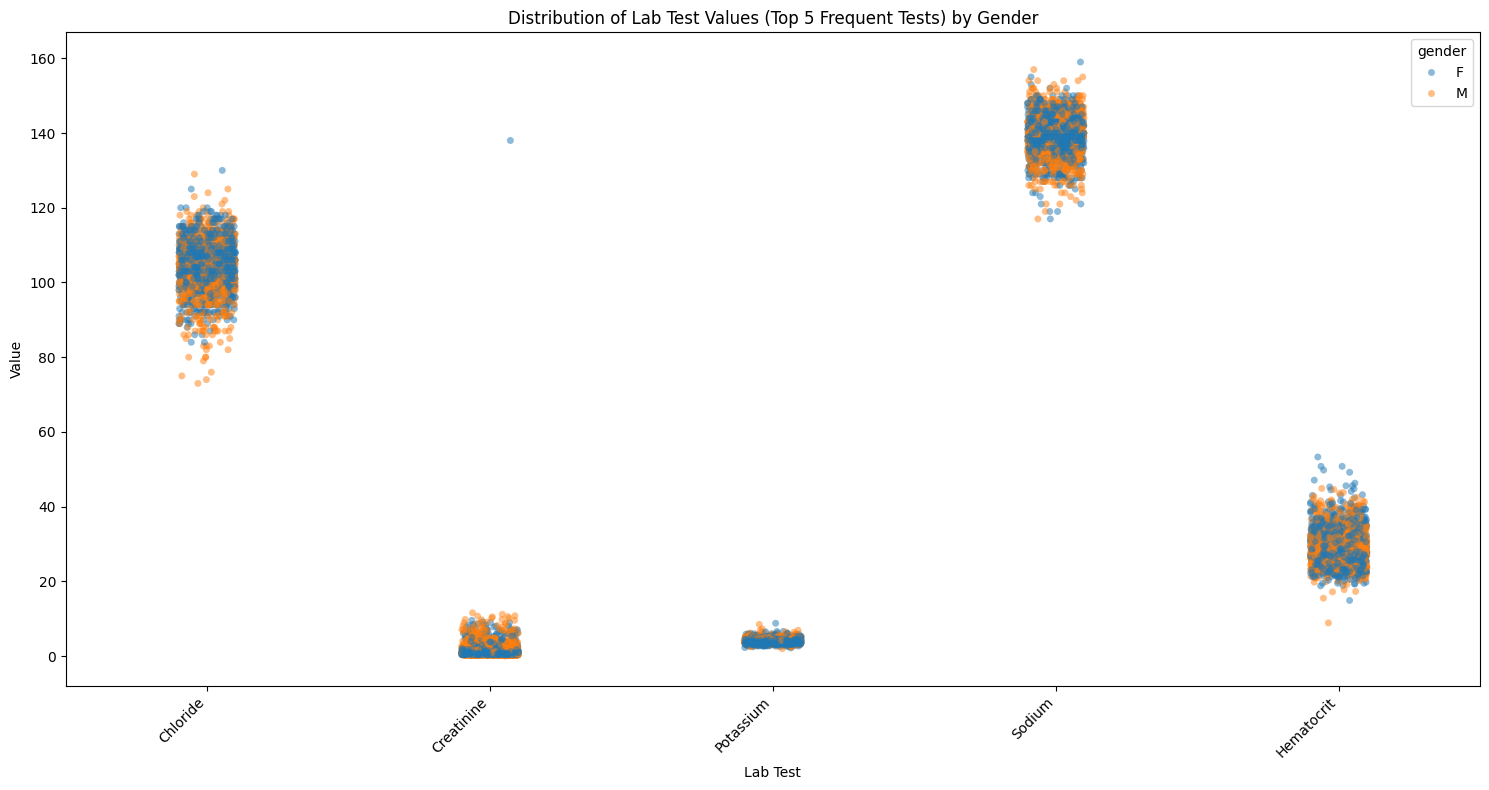

In [243]:
# Get the top 5 most common lab tests
top_5_tests = merged_lab_data['itemid'].value_counts().head(5)

# Print the top 5 tests with their labels
print("Top 5 most common lab tests:")
for itemid, count in top_5_tests.items():
    print(f"{lab_dict[itemid]}: {count} measurements")

# Filter data for top 5 tests
filtered_data = merged_lab_data[merged_lab_data['itemid'].isin(top_5_tests.index)].copy()

# Map itemids to labels
filtered_data['label'] = filtered_data['itemid'].map(lab_dict)

# Create the swarm plot
plt.figure(figsize=(15, 8))
sns.stripplot(data=filtered_data, x='label', y='valuenum', hue='gender', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Lab Test Values (Top 5 Frequent Tests) by Gender')
plt.xlabel('Lab Test')
plt.ylabel('Value')
plt.tight_layout()

### Percentage of Abnormal Lab Tests By Age

Helps visualize which ages have the highest percentages of abnormal tests.

<Figure size 1000x800 with 0 Axes>

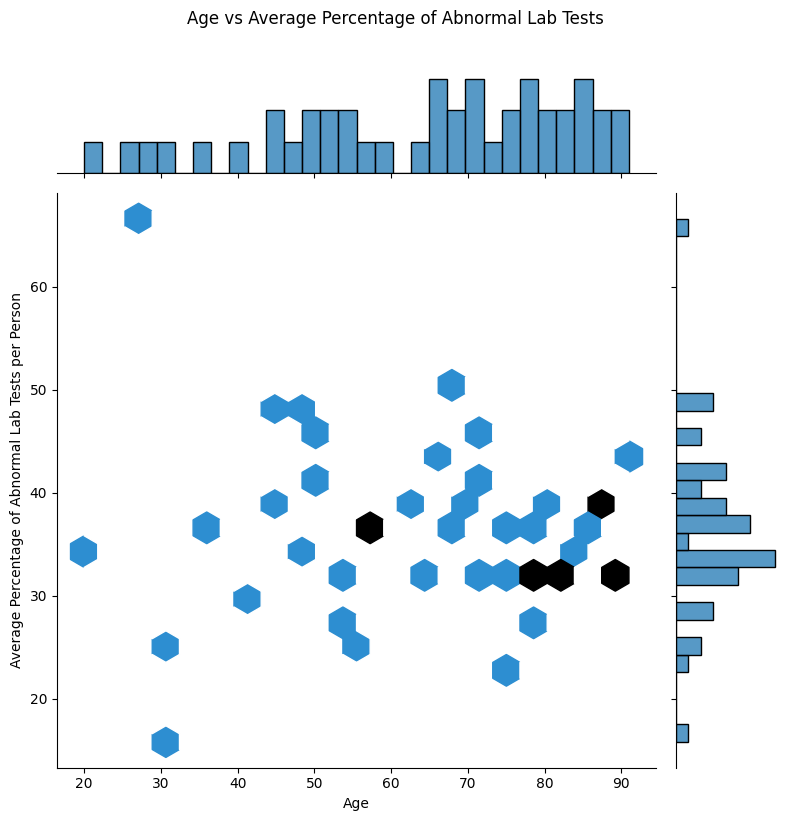

In [244]:
# Calculate percentage of abnormal tests for each patient
patient_stats = merged_lab_data.groupby(['subject_id', 'age', 'gender']).agg({  # Added 'gender' here
    'flag': ['size', lambda x: (x == 'abnormal').sum()]  # Total tests and abnormal tests count
}).reset_index()

# Rename columns for clarity
patient_stats.columns = ['subject_id', 'age', 'gender', 'total_tests', 'abnormal_count']  # Added 'gender' here

# Calculate percentage of abnormal tests
patient_stats['abnormal_percentage'] = (patient_stats['abnormal_count'] / patient_stats['total_tests']) * 100

# Calculate average percentage for each age group
age_averages = patient_stats.groupby('age')['abnormal_percentage'].agg([
    'mean',           # average percentage of abnormal tests
    'count',          # number of people in age group
    'std'            # standard deviation for error bars
]).reset_index()

# Create jointplot
plt.figure(figsize=(10, 8))
sns.jointplot(
    data=age_averages,
    x='age',
    y='mean',
    kind='hex',
    height=8,
    joint_kws={'gridsize': 20},
    marginal_kws={'bins': 30}
)
plt.xlabel('Age')
plt.ylabel('Average Percentage of Abnormal Lab Tests per Person')
plt.suptitle('Age vs Average Percentage of Abnormal Lab Tests', y=1.02)
plt.tight_layout()

### Percentage of Abnormal Lab Tests By Age and Gender

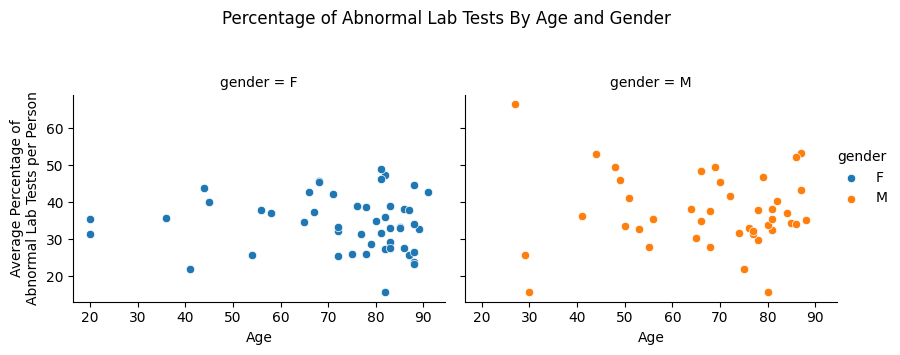

In [245]:
# Create a facet grid of scatter plots for each gender with adjusted size and spacing
g = sns.FacetGrid(patient_stats, col='gender', hue='gender', height=3.5, aspect=1.2)
g.map(sns.scatterplot, 'age', 'abnormal_percentage')
g.add_legend()

# Set labels with more space
g.set_axis_labels('Age', 'Average Percentage of\nAbnormal Lab Tests per Person')

# Add title with proper spacing
g.fig.suptitle('Percentage of Abnormal Lab Tests By Age and Gender', y=1.0)

# Adjust layout to prevent cutting off
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

### Abnormal Tests Correlation (For tests that are top 25 frequently abnormal)

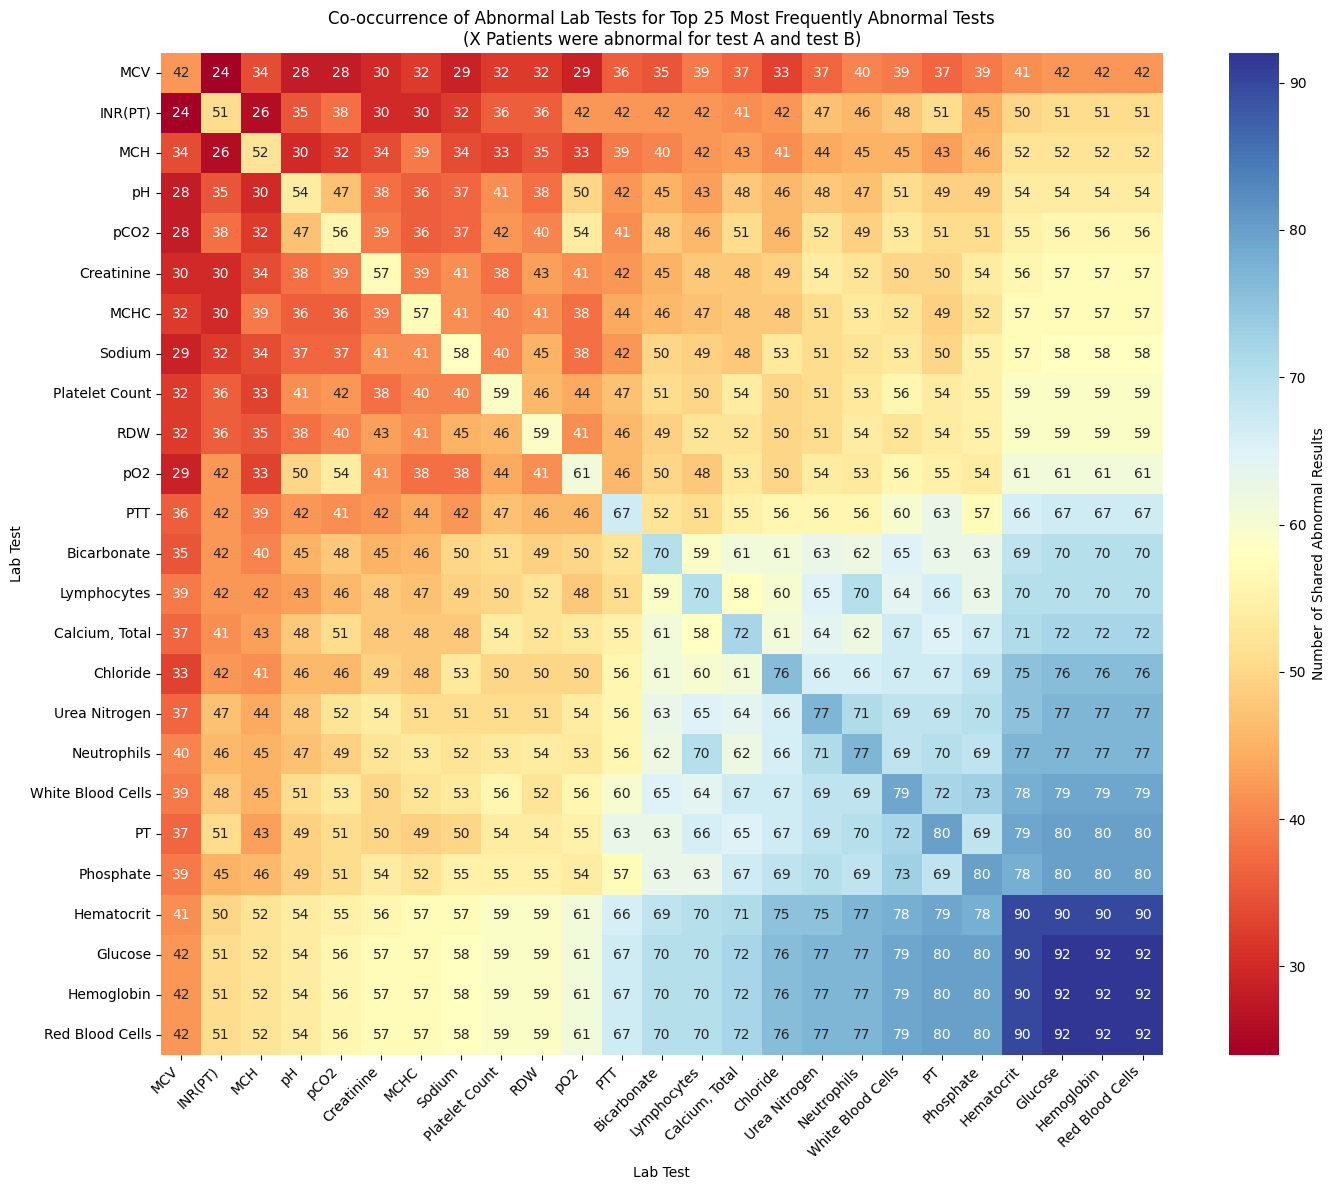

In [246]:
# Add a new 'label' column that maps itemid to lab test names
merged_lab_data['label'] = merged_lab_data['itemid'].map(lab_dict)

# Now get the top 25 most frequently abnormal tests
top_abnormal_tests = merged_lab_data[merged_lab_data['flag'].notna()].groupby('label')['flag'].count().sort_values(ascending=False).head(25).index

# Filter data for just those tests
filtered_data = merged_lab_data[merged_lab_data['label'].isin(top_abnormal_tests)]

# Create binary pivot table (1 if abnormal, 0 if not)
abnormal_pivot = pd.crosstab(
    filtered_data[filtered_data['flag'].notna()]['subject_id'],
    filtered_data[filtered_data['flag'].notna()]['label'],
    values=1,
    aggfunc='count'
)

# Convert to binary (0/1) values
abnormal_pivot = (abnormal_pivot > 0).astype(int)

# Calculate co-occurrence matrix
cooccurrence_matrix = pd.DataFrame(abnormal_pivot.T @ abnormal_pivot)

# Get the diagonal values (total abnormal counts for each test)
test_order = pd.Series(np.diag(cooccurrence_matrix), index=cooccurrence_matrix.index)

# Sort the matrix rows and columns based on these counts
cooccurrence_matrix = cooccurrence_matrix.loc[test_order.sort_values().index, 
                                            test_order.sort_values().index]

# Create heatmap
plt.figure(figsize=(15,12))
sns.heatmap(
    cooccurrence_matrix,
    annot=True,
    cmap='RdYlBu',
    fmt='d',
    square=True,
    cbar_kws={'label': 'Number of Shared Abnormal Results'}
)
plt.title('Co-occurrence of Abnormal Lab Tests for Top 25 Most Frequently Abnormal Tests\n(X Patients were abnormal for test A and test B)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Lab Test')
plt.ylabel('Lab Test')
plt.tight_layout()
plt.show()

### Count of Lab Tests Over Time

In [247]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Merge datasets
merged_data = lab_events.merge(lab_items, on='itemid')

# Group by date and label, get counts
daily_counts = merged_data.groupby([merged_data['charttime'].dt.date, 'label']).size().reset_index()
daily_counts.columns = ['date', 'label', 'count']

# Create the figure with dropdown
fig = go.Figure()

# Add traces for each lab test
for test in daily_counts['label'].unique():
    test_data = daily_counts[daily_counts['label'] == test]
    fig.add_trace(
        go.Scatter(
            x=test_data['date'],
            y=test_data['count'],
            name=test,
            visible=False
        )
    )

# Make the first trace visible
fig.data[0].visible = True

# Create dropdown menu
buttons = []
for i, test in enumerate(daily_counts['label'].unique()):
    visibility = [False] * len(daily_counts['label'].unique())
    visibility[i] = True
    buttons.append(
        dict(
            label=test,
            method="update",
            args=[{"visible": visibility},
                  {"title": f"Count of {test} Tests Over Time"}]
        )
    )

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True
        )
    ],
    title={
        'text': f"Count of {daily_counts['label'].iloc[0]} Tests Over Time",
        'x': 0.5,
    },
    xaxis_title="Date",
    yaxis_title="Count",
    height=700,
    width=1000
)

# Show the figure
fig.show()

## Analyze Procedures Data (Using the Bokeh, Altair, and WordCloud Library)

This is very similar to Diagnosis Data Analysis from Tutorial

In [248]:
merged_procedures_data = pd.merge(procedures, filtered_patients, on='subject_id')

# Get dictionary of procedure icd9_code -> short_title
procedure_dict = procedures_labels.set_index('icd9_code')['short_title'].to_dict()
procedure_long_title_dict = procedures_labels.set_index('icd9_code')['long_title'].to_dict()


In [249]:
# Get the top procedures codes for each gender
top_procedures_codes_male = merged_procedures_data[merged_procedures_data['gender'] == 'M']['icd9_code'].value_counts().head(10)
top_procedures_codes_female = merged_procedures_data[merged_procedures_data['gender'] == 'F']['icd9_code'].value_counts().head(10)

### Visualizing using Bokeh (Interactive Plot - Hover to show long title)

In [250]:
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.io import output_notebook, show

# Enable notebook output
output_notebook()

# Create DataFrames with procedure names
male_data = pd.DataFrame({
    'procedure': [procedure_dict.get(code, code) for code in top_procedures_codes_male.index],
    'count': top_procedures_codes_male.values,
    'long_title': [procedure_long_title_dict.get(code, code) for code in top_procedures_codes_male.index]
})

female_data = pd.DataFrame({
    'procedure': [procedure_dict.get(code, code) for code in top_procedures_codes_female.index],
    'count': top_procedures_codes_female.values,
    'long_title': [procedure_long_title_dict.get(code, code) for code in top_procedures_codes_female.index]
})

# Create male figure
p1 = figure(x_range=male_data['procedure'].tolist(),
           height=400, width=800,
           title="Top 10 Procedures - Male Patients")

p1.vbar(x='procedure', top='count',
        width=0.4,
        source=male_data,
        color='blue',
        alpha=0.7)

# Create female figure
p2 = figure(x_range=female_data['procedure'].tolist(),
           height=400, width=800,
           title="Top 10 Procedures - Female Patients")

p2.vbar(x='procedure', top='count',
        width=0.4,
        source=female_data,
        color='red',
        alpha=0.7)

# Add hover tools
hover_tool = HoverTool(tooltips=[
    ('Procedure', '@procedure'),
    ('Count', '@count'),
    ('Long Title', '@long_title')
])

# Customize both plots
for p in [p1, p2]:
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = 45
    p.yaxis.axis_label = "Count"
    p.xaxis.axis_label = "Procedure Short Title"
    p.add_tools(hover_tool)

# Show the plots
show(column(p1, p2))

Loading BokehJS ...

### Visualizing the same data using Altair (Interactive Plot - Hover to show long title)

In [251]:
import altair as alt

# Create separate plots for male and female patients with enhanced tooltips
male_data = pd.DataFrame({
    'procedure': [procedure_dict.get(code, code) for code in top_procedures_codes_male.index],
    'long_title': [procedure_long_title_dict.get(code, code) for code in top_procedures_codes_male.index],
    'count': top_procedures_codes_male.values,
    'gender': ['Male'] * len(top_procedures_codes_male)
})

female_data = pd.DataFrame({
    'procedure': [procedure_dict.get(code, code) for code in top_procedures_codes_female.index],
    'long_title': [procedure_long_title_dict.get(code, code) for code in top_procedures_codes_female.index],
    'count': top_procedures_codes_female.values,
    'gender': ['Female'] * len(top_procedures_codes_female)
})

# Create male chart
male_chart = alt.Chart(male_data).mark_bar().encode(
    x=alt.X('procedure:N', sort='-y', axis=alt.Axis(labelAngle=45), title="Procedure Short Title"),
    y=alt.Y('count:Q', title="Count"),
    color=alt.value('#1f77b4'),  # Blue for males
    tooltip=['procedure', 'long_title', 'count']
).properties(
    width=400,
    height=300,
    title='Top 10 Procedures - Male Patients'
).interactive()

# Create female chart
female_chart = alt.Chart(female_data).mark_bar().encode(
    x=alt.X('procedure:N', sort='-y', axis=alt.Axis(labelAngle=45), title="Procedure Short Title"),
    y=alt.Y('count:Q', title="Count"),
    color=alt.value('#e377c2'),  # Pink for females
    tooltip=['procedure', 'long_title', 'count']
).properties(
    width=400,
    height=300,
    title='Top 10 Procedures - Female Patients'
).interactive()

# Combine charts side by side
final_chart = alt.hconcat(male_chart, female_chart)
final_chart

alt.HConcatChart(...)

### Visualizing the same data using WordCloud

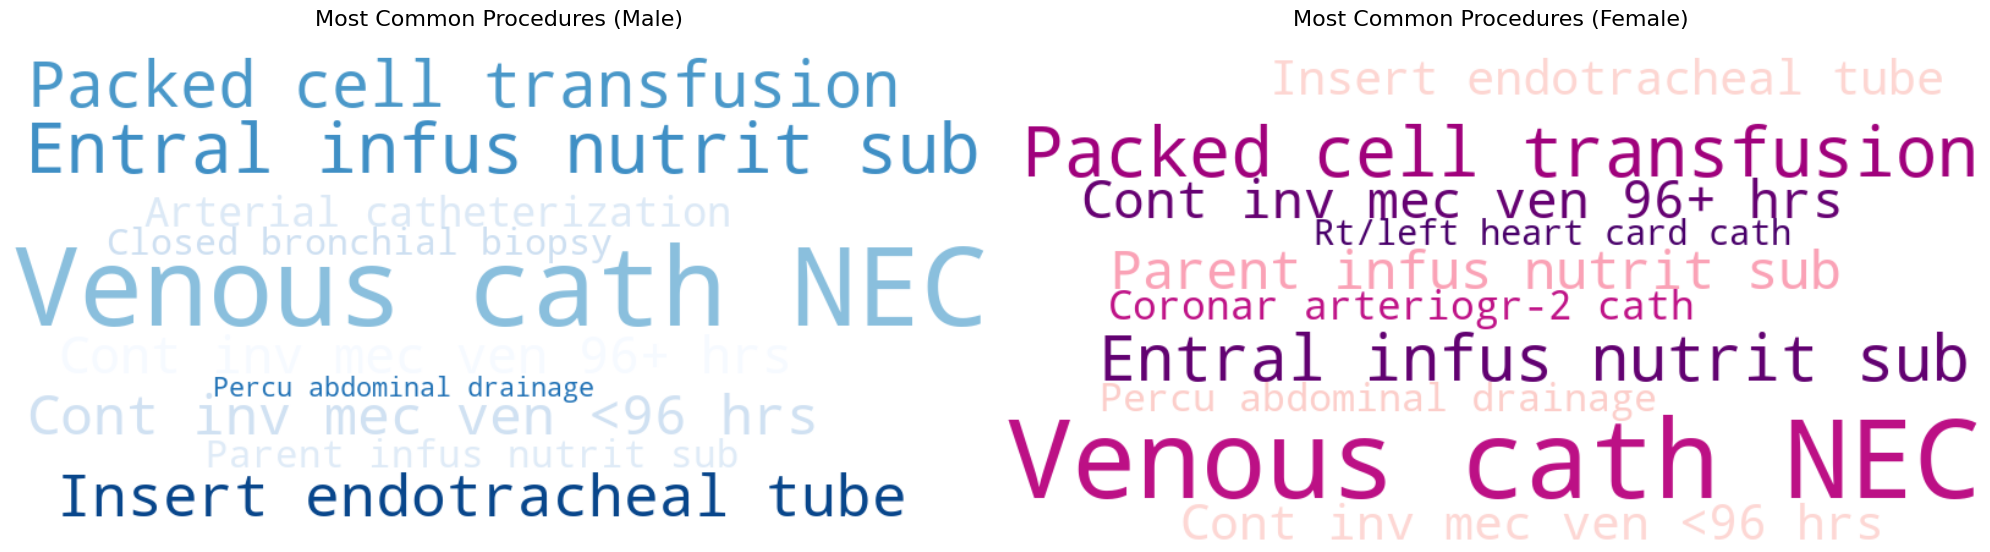

In [252]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the Series to dictionaries where procedure names (not codes) map to frequencies
male_proc_freq = {procedure_dict[code]: count 
                 for code, count in top_procedures_codes_male.items()}
female_proc_freq = {procedure_dict[code]: count 
                   for code, count in top_procedures_codes_female.items()}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Generate male procedures word cloud
wordcloud_male = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='Blues',
    prefer_horizontal=0.7,
    max_font_size=100
).generate_from_frequencies(male_proc_freq)

# Generate female procedures word cloud
wordcloud_female = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='RdPu',
    prefer_horizontal=0.7,
    max_font_size=100
).generate_from_frequencies(female_proc_freq)

# Plot male procedures
ax1.imshow(wordcloud_male, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Most Common Procedures (Male)', fontsize=16, pad=20)

# Plot female procedures
ax2.imshow(wordcloud_female, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most Common Procedures (Female)', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

### Analyze the Relation Between Procedure Count and Age (Interactive Plot - Hover to see age, gender, and count)

#### Each dot represents a subject

In [253]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool

# Enable notebook output
output_notebook()

# Prepare the data
procedures_per_patient = merged_procedures_data.groupby(['subject_id', 'age', 'gender']).size().reset_index()
procedures_per_patient.columns = ['subject_id', 'age', 'gender', 'procedure_count']

# Create separate data sources for each gender
male_source = ColumnDataSource(procedures_per_patient[procedures_per_patient['gender'] == 'M'])
female_source = ColumnDataSource(procedures_per_patient[procedures_per_patient['gender'] == 'F'])

# Create the figure
p = figure(height=500, width=800,
           title="Number of Procedures vs Age by Gender (Each Dot is a Subject)",
           x_axis_label='Age',
           y_axis_label='Number of Procedures')

# Add hover tool
hover = HoverTool(tooltips=[
    ('Age', '@age'),
    ('Procedures', '@procedure_count'),
    ('Gender', '@gender')
])
p.add_tools(hover)

# Add scatter points for each gender
p.circle('age', 'procedure_count', size=8, alpha=0.5, color='blue', 
         legend_label='Male', source=male_source)
p.circle('age', 'procedure_count', size=8, alpha=0.5, color='red', 
         legend_label='Female', source=female_source)

# Customize the plot
p.legend.click_policy = "hide"  # Allow toggling of gender visibility
p.grid.grid_line_alpha = 0.3
p.legend.location = "top_right"

# Show the plot
show(p)

Loading BokehJS ...